In [ ]:
import torch
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt 
import matplotlib.image as image 
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
import tqdm

# 1. Prepare Datasets 
## 1.1 ImageFolder
### 1.1.1 aug_data_set_from_me

In [ ]:
my_path = './aug_data_set-20210519T203344Z-001/aug_data_set'

In [ ]:
mydata_transforms = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
my_image_datasets = datasets.ImageFolder(my_path, mydata_transforms)
len_my_images = len(my_image_datasets)

In [ ]:
my_train_dataset, my_test_dataset = torch.utils.data.random_split(my_image_datasets, [int(0.8*len_my_images), len_my_images - int(0.8*len_my_images)])

In [ ]:
my_train_set, my_val_set = torch.utils.data.random_split(my_train_dataset,[int(len(my_train_dataset)*0.9),int(len(my_train_dataset)*0.1)])

### 1.1.2 aug_data_from_(train)mnist

In [ ]:
mnist_path = "C:/Users/User/dl_term_p/aug_data_set_by_mnist/"

In [ ]:
mnistdata_transforms = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
mnist_image_datasets = datasets.ImageFolder(mnist_path, mnistdata_transforms)
len_mnist_images = len(mnist_image_datasets)

In [ ]:
mnist_train_dataset, mnist_test_dataset = torch.utils.data.random_split(mnist_image_datasets, [int(0.8*len_mnist_images), len_mnist_images - int(0.8*len_mnist_images)])

In [ ]:
mnist_train_set, mnist_val_set = torch.utils.data.random_split(mnist_train_dataset,[int(len(mnist_train_dataset)*0.9),int(len(mnist_train_dataset)*0.1)])

## 1.2 concate train/val/test data

In [ ]:
train_set = torch.utils.data.ConcatDataset([my_train_set, mnist_train_set])
val_set = torch.utils.data.ConcatDataset([my_val_set, mnist_val_set])
test_set = torch.utils.data.ConcatDataset([my_test_dataset, mnist_test_dataset])

## 1.3 DataLoader

### 1.3.1 batch_size = 200, lr=0.0005

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

# 2. Model

In [ ]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        n_channels_1 = 6
        n_channels_2 = 16
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, n_channels_1, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)            
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_channels_1, n_channels_2, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc3 = torch.nn.Linear(4*4*n_channels_2, 120, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc3,
            torch.nn.ReLU(),
            #torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc4 = torch.nn.Linear(120,80, bias=True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc4,
            torch.nn.ReLU(),
            #torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc5 = torch.nn.Linear(80,10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        
        #Softmax is included in nn.CrossEntropyLoss
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten them for FC

        out = self.layer3(out)
        out = self.layer4(out)

        out = self.fc5(out)
        return out

In [ ]:
class CNN_dropout(torch.nn.Module):
    
    def __init__(self):
        super(CNN_dropout, self).__init__()
        self.keep_prob = 0.5
        
        n_channels_1 = 6
        n_channels_2 = 16
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, n_channels_1, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)            
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_channels_1, n_channels_2, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc3 = torch.nn.Linear(4*4*n_channels_2, 120, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc3,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc4 = torch.nn.Linear(120,80, bias=True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc4,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc5 = torch.nn.Linear(80,10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        
        #Softmax is included in nn.CrossEntropyLoss
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten them for FC

        out = self.layer3(out)
        out = self.layer4(out)

        out = self.fc5(out)
        return out

In [ ]:
class CNN_bn(torch.nn.Module):
    
    def __init__(self):
        super(CNN_bn, self).__init__()
        self.keep_prob = 0.5
        
        n_channels_1 = 6
        n_channels_2 = 16
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, n_channels_1, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            #batchNorm2d 추가
            torch.nn.BatchNorm2d(n_channels_1)
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_channels_1, n_channels_2, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            #batchNorm2d 추가
            torch.nn.BatchNorm2d(n_channels_2)
        )
        
        self.fc3 = torch.nn.Linear(4*4*n_channels_2, 120, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc3,
            torch.nn.ReLU(),
            #batchNorm1d 추가
            torch.nn.BatchNorm1d(120),
            torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc4 = torch.nn.Linear(120,80, bias=True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc4,
            torch.nn.ReLU(),
            #batchNorm1d 추가
            torch.nn.BatchNorm1d(80),
            torch.nn.Dropout(p=1-self.keep_prob)
        )
        
        self.fc5 = torch.nn.Linear(80,10,bias=True)
        #batchNorm1d 추가
        torch.nn.BatchNorm1d(10)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        
        #Softmax is included in nn.CrossEntropyLoss
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten them for FC

        out = self.layer3(out)
        out = self.layer4(out)

        out = self.fc5(out)
        return out

In [ ]:
def train_with_epochs(number_of_epochs, model, criterion, optimizer, pt_name):
    # n_epochs = 40
    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses= []
    # epoch당 average training loss를 track
    avg_train_losses= []
    # epoch당 average validation loss를 track
    avg_valid_losses= []
    
    # epoch당 정확도를 track
    train_accs= []
    valid_accs= []
    
    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=pt_name)

    for epoch in range(1, number_of_epochs + 1):



        ###################
        # train the model #
        ###################
        model.train() # 모델을 train시작한다
        #RM :cost = 0 # 예측값과 실제값 차이의 제곱합 
        #RM : n_batches = 0 

        #parameter 계혹 업데이트 
        for X, Y in tqdm.tqdm(train_loader): #미니배치단위로 꺼내온다 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(X)
            # calculate the loss
            loss =criterion(output, Y)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
        #model.eval()

        for X , Y in tqdm.tqdm(dev_loader) :
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(X)
            # calculate the loss
            loss = criterion(output, Y)
            # record validation loss
            valid_losses.append(loss.item())

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        #train_accs.append(test(train_loader,model1))
        #valid_accs.append(test(dev_loader,model1))

        epoch_len = len(str(number_of_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{number_of_epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load(pt_name))
    return model, avg_train_losses, avg_valid_losses


In [ ]:
def test(data_loader, model):
    model.eval() # 반드시 필요하다
    n_predict = 0
    n_correct = 0
    with torch.no_grad():
        for x, y in tqdm.tqdm(data_loader):
            y_hat = model(x)
            y_hat.argmax()
            
            _, predicted = torch.max(y_hat,1)
            
            n_predict += len(predicted)
            n_correct += (y == predicted).sum()
            
        accuracy = n_correct/n_predict
        print(f"Accuracy: {accuracy} ()")
        return accuracy.item()

In [ ]:
def plot_loss(train_loss, valid_loss, title_name, save_name):
    # 훈련이 진행되는 과정에 따라 loss를 시각화
    fig = plt.figure(figsize=(6,4))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # validation loss의 최저값 지점을 찾기
    minposs = valid_loss.index(min(valid_loss))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(title_name)
    plt.ylim(0, 2.3) # 일정한 scale
    plt.xlim(0, len(train_loss)+1) # 일정한 scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(title_name+'.png', bbox_inches = 'tight')

## 2.1 model1 - no dropout / no batchnomal / 64 / 1e-3

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

In [ ]:
model1=CNN()
criterion1 = torch.nn.CrossEntropyLoss() # 비용함수에 소프트 맥스 함수 포함되어져 있음
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001) # Adam을 사용함

In [ ]:
model1, train_loss1, valid_loss1 = train_with_epochs(100, model1, criterion1, optimizer1,'model1.pt')

  0%|▏                                                                                 | 2/962 [00:00<01:23, 11.56it/s]

[  1/100] train_loss: 1.11511 valid_loss: 0.86415
Validation loss decreased (inf --> 0.864151).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:52,  8.56it/s]

[  2/100] train_loss: 0.71683 valid_loss: 0.64393
Validation loss decreased (0.864151 --> 0.643926).  Saving model ...


  0%|▏                                                                                 | 2/962 [00:00<01:38,  9.74it/s]

[  3/100] train_loss: 0.58356 valid_loss: 0.57540
Validation loss decreased (0.643926 --> 0.575400).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:23,  6.71it/s]

[  4/100] train_loss: 0.50651 valid_loss: 0.51855
Validation loss decreased (0.575400 --> 0.518554).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:38,  9.80it/s]

[  5/100] train_loss: 0.45153 valid_loss: 0.51901
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<01:47,  8.93it/s]

[  6/100] train_loss: 0.40968 valid_loss: 0.51464
Validation loss decreased (0.518554 --> 0.514643).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:44,  9.17it/s]

[  7/100] train_loss: 0.37986 valid_loss: 0.48899
Validation loss decreased (0.514643 --> 0.488990).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:00,  8.00it/s]

[  8/100] train_loss: 0.34979 valid_loss: 0.48462
Validation loss decreased (0.488990 --> 0.484618).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:38,  9.80it/s]

[  9/100] train_loss: 0.32659 valid_loss: 0.48944
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<01:45,  9.09it/s]

[ 10/100] train_loss: 0.30612 valid_loss: 0.51144
EarlyStopping counter: 2 out of 10


  0%|▏                                                                                 | 2/962 [00:00<01:26, 11.07it/s]

[ 11/100] train_loss: 0.28809 valid_loss: 0.50200
EarlyStopping counter: 3 out of 10


  0%|                                                                                          | 0/962 [00:00<?, ?it/s]

[ 12/100] train_loss: 0.26969 valid_loss: 0.52869
EarlyStopping counter: 4 out of 10


  0%|                                                                                  | 1/962 [00:00<02:03,  7.75it/s]

[ 13/100] train_loss: 0.25761 valid_loss: 0.54133
EarlyStopping counter: 5 out of 10


  0%|                                                                                  | 1/962 [00:00<01:57,  8.20it/s]

[ 14/100] train_loss: 0.24192 valid_loss: 0.53541
EarlyStopping counter: 6 out of 10


  0%|                                                                                  | 1/962 [00:00<02:20,  6.82it/s]

[ 15/100] train_loss: 0.23101 valid_loss: 0.54215
EarlyStopping counter: 7 out of 10


  0%|▏                                                                                 | 2/962 [00:00<01:18, 12.27it/s]

[ 16/100] train_loss: 0.22043 valid_loss: 0.57453
EarlyStopping counter: 8 out of 10


  0%|▏                                                                                 | 2/962 [00:00<01:31, 10.47it/s]

[ 17/100] train_loss: 0.20845 valid_loss: 0.58624
EarlyStopping counter: 9 out of 10


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:08<00:00, 12.13it/s]

[ 18/100] train_loss: 0.20339 valid_loss: 0.57582
EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
test(train_loader,model1)

100%|████████████████████████████████████████████████████████████████████████████████| 962/962 [02:11<00:00,  7.30it/s]

Accuracy: 0.9016081690788269 ()


0.9016081690788269

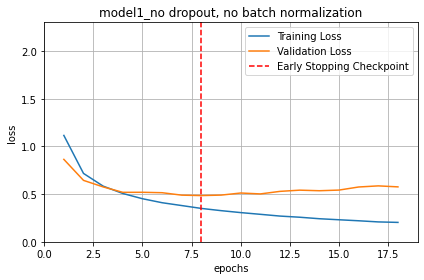

In [ ]:
plot_loss(train_loss1, valid_loss1, 'model1_no dropout, no batch normalization', 'model1')

## 2.2 model2 -  dropout / no batch normalization / 64 / 1e-3

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

In [ ]:
model2 = CNN_dropout()
criterion2 = torch.nn.CrossEntropyLoss() # 비용함수에 소프트 맥스 함수 포함되어져 있음
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001) # Adam을 사용함

In [ ]:
model2, train_loss2, valid_loss2 = train_with_epochs(100, model2, criterion2, optimizer2,'model2.pt')

  0%|                                                                                  | 1/962 [00:00<02:11,  7.31it/s]

[  1/100] train_loss: 1.56214 valid_loss: 1.17021
Validation loss decreased (inf --> 1.170205).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:48,  8.85it/s]

[  2/100] train_loss: 1.04962 valid_loss: 0.98681
Validation loss decreased (1.170205 --> 0.986812).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:48,  8.85it/s]

[  3/100] train_loss: 0.91973 valid_loss: 0.89458
Validation loss decreased (0.986812 --> 0.894578).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:46,  9.01it/s]

[  4/100] train_loss: 0.85024 valid_loss: 0.86056
Validation loss decreased (0.894578 --> 0.860558).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:56,  8.26it/s]

[  5/100] train_loss: 0.80468 valid_loss: 0.84306
Validation loss decreased (0.860558 --> 0.843061).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:01,  7.91it/s]

[  6/100] train_loss: 0.76828 valid_loss: 0.82147
Validation loss decreased (0.843061 --> 0.821466).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:54,  8.40it/s]

[  7/100] train_loss: 0.73910 valid_loss: 0.78250
Validation loss decreased (0.821466 --> 0.782500).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:51,  8.62it/s]

[  8/100] train_loss: 0.72579 valid_loss: 0.76716
Validation loss decreased (0.782500 --> 0.767156).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:55,  8.33it/s]

[  9/100] train_loss: 0.71218 valid_loss: 0.76821
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:01,  7.94it/s]

[ 10/100] train_loss: 0.69250 valid_loss: 0.74978
Validation loss decreased (0.767156 --> 0.749775).  Saving model ...


  0%|                                                                                          | 0/962 [00:00<?, ?it/s]

[ 11/100] train_loss: 0.68056 valid_loss: 0.74243
Validation loss decreased (0.749775 --> 0.742429).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:02,  7.88it/s]

[ 12/100] train_loss: 0.67286 valid_loss: 0.74595
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:06,  7.58it/s]

[ 13/100] train_loss: 0.66090 valid_loss: 0.74098
Validation loss decreased (0.742429 --> 0.740981).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:48,  8.85it/s]

[ 14/100] train_loss: 0.65080 valid_loss: 0.71543
Validation loss decreased (0.740981 --> 0.715429).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:50,  8.70it/s]

[ 15/100] train_loss: 0.64487 valid_loss: 0.74886
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<01:53,  8.47it/s]

[ 16/100] train_loss: 0.63506 valid_loss: 0.74885
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<01:52,  8.55it/s]

[ 17/100] train_loss: 0.62905 valid_loss: 0.71611
EarlyStopping counter: 3 out of 10


  0%|                                                                                  | 1/962 [00:00<02:03,  7.75it/s]

[ 18/100] train_loss: 0.62158 valid_loss: 0.74226
EarlyStopping counter: 4 out of 10


  0%|                                                                                  | 1/962 [00:00<01:59,  8.06it/s]

[ 19/100] train_loss: 0.62142 valid_loss: 0.72550
EarlyStopping counter: 5 out of 10


  0%|                                                                                  | 1/962 [00:00<02:06,  7.58it/s]

[ 20/100] train_loss: 0.61394 valid_loss: 0.71753
EarlyStopping counter: 6 out of 10


  0%|                                                                                  | 1/962 [00:00<01:46,  9.01it/s]

[ 21/100] train_loss: 0.60289 valid_loss: 0.70567
Validation loss decreased (0.715429 --> 0.705675).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:55,  8.33it/s]

[ 22/100] train_loss: 0.60452 valid_loss: 0.71162
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:20,  6.86it/s]

[ 23/100] train_loss: 0.60078 valid_loss: 0.71957
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<02:16,  7.04it/s]

[ 24/100] train_loss: 0.59427 valid_loss: 0.71883
EarlyStopping counter: 3 out of 10


  0%|                                                                                  | 1/962 [00:00<02:31,  6.33it/s]

[ 25/100] train_loss: 0.58993 valid_loss: 0.71166
EarlyStopping counter: 4 out of 10


  0%|                                                                                  | 1/962 [00:00<02:16,  7.04it/s]

[ 26/100] train_loss: 0.59273 valid_loss: 0.70980
EarlyStopping counter: 5 out of 10


  0%|                                                                                  | 1/962 [00:00<02:16,  7.04it/s]

[ 27/100] train_loss: 0.58758 valid_loss: 0.71899
EarlyStopping counter: 6 out of 10


  0%|                                                                                  | 1/962 [00:00<02:14,  7.14it/s]

[ 28/100] train_loss: 0.58451 valid_loss: 0.71457
EarlyStopping counter: 7 out of 10


  0%|                                                                                  | 1/962 [00:00<02:01,  7.94it/s]

[ 29/100] train_loss: 0.58145 valid_loss: 0.69248
Validation loss decreased (0.705675 --> 0.692476).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:49,  8.77it/s]

[ 30/100] train_loss: 0.57625 valid_loss: 0.71441
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:05,  7.65it/s]

[ 31/100] train_loss: 0.57712 valid_loss: 0.73571
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<02:04,  7.72it/s]

[ 32/100] train_loss: 0.57421 valid_loss: 0.72768
EarlyStopping counter: 3 out of 10


  0%|                                                                                  | 1/962 [00:00<01:53,  8.50it/s]

[ 33/100] train_loss: 0.57026 valid_loss: 0.72088
EarlyStopping counter: 4 out of 10


  0%|                                                                                  | 1/962 [00:00<01:46,  8.99it/s]

[ 34/100] train_loss: 0.56931 valid_loss: 0.71872
EarlyStopping counter: 5 out of 10


  0%|                                                                                  | 1/962 [00:00<02:02,  7.87it/s]

[ 35/100] train_loss: 0.56345 valid_loss: 0.70250
EarlyStopping counter: 6 out of 10


  0%|                                                                                  | 1/962 [00:00<01:55,  8.29it/s]

[ 36/100] train_loss: 0.56640 valid_loss: 0.70055
EarlyStopping counter: 7 out of 10


  0%|                                                                                  | 1/962 [00:00<01:38,  9.76it/s]

[ 37/100] train_loss: 0.56098 valid_loss: 0.69692
EarlyStopping counter: 8 out of 10


  0%|                                                                                  | 1/962 [00:00<01:57,  8.19it/s]

[ 38/100] train_loss: 0.55075 valid_loss: 0.72358
EarlyStopping counter: 9 out of 10


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:11<00:00,  9.68it/s]

[ 39/100] train_loss: 0.55732 valid_loss: 0.73154
EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
test(test_loader,model2)

100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [01:06<00:00,  4.03it/s]

Accuracy: 0.8280701637268066 ()


0.8280701637268066

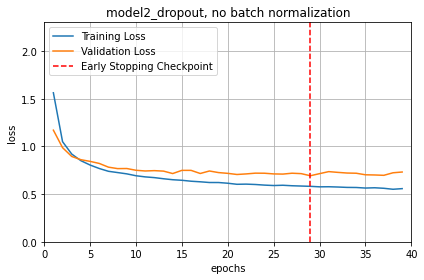

In [ ]:
plot_loss(train_loss2, valid_loss2, 'model2_dropout, no batch normalization', 'model2')

## 2.3 model3 - dropout / batch normalization / 64 / 1e-3

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

In [ ]:
model3 = CNN_bn()
criterion3 = torch.nn.CrossEntropyLoss() # 비용함수에 소프트 맥스 함수 포함되어져 있음
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001) # Adam을 사용함

In [ ]:
model3, train_loss3, valid_loss3 = train_with_epochs(100, model3, criterion3, optimizer3,'model3.pt')

  0%|                                                                                  | 1/962 [00:00<02:01,  7.90it/s]

[  1/100] train_loss: 1.72074 valid_loss: 1.36997
Validation loss decreased (inf --> 1.369973).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:07,  7.51it/s]

[  2/100] train_loss: 1.11977 valid_loss: 1.11608
Validation loss decreased (1.369973 --> 1.116075).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:03,  7.81it/s]

[  3/100] train_loss: 0.96180 valid_loss: 1.00673
Validation loss decreased (1.116075 --> 1.006735).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:58,  8.13it/s]

[  4/100] train_loss: 0.87263 valid_loss: 0.92468
Validation loss decreased (1.006735 --> 0.924682).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:09,  7.44it/s]

[  5/100] train_loss: 0.81661 valid_loss: 0.87734
Validation loss decreased (0.924682 --> 0.877344).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:12,  7.27it/s]

[  6/100] train_loss: 0.77548 valid_loss: 0.83432
Validation loss decreased (0.877344 --> 0.834324).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:56,  8.23it/s]

[  7/100] train_loss: 0.74642 valid_loss: 0.81365
Validation loss decreased (0.834324 --> 0.813649).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:09,  7.41it/s]

[  8/100] train_loss: 0.72584 valid_loss: 0.79184
Validation loss decreased (0.813649 --> 0.791841).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:44,  5.85it/s]

[  9/100] train_loss: 0.70619 valid_loss: 0.79791
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:33,  6.27it/s]

[ 10/100] train_loss: 0.68945 valid_loss: 0.77287
Validation loss decreased (0.791841 --> 0.772875).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:07,  7.55it/s]

[ 11/100] train_loss: 0.67801 valid_loss: 0.77977
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:03,  7.79it/s]

[ 12/100] train_loss: 0.66301 valid_loss: 0.78159
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<01:59,  8.07it/s]

[ 13/100] train_loss: 0.65676 valid_loss: 0.75499
Validation loss decreased (0.772875 --> 0.754988).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:18,  6.96it/s]

[ 14/100] train_loss: 0.65163 valid_loss: 0.75282
Validation loss decreased (0.754988 --> 0.752823).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:50,  8.66it/s]

[ 15/100] train_loss: 0.63824 valid_loss: 0.75338
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:19,  6.88it/s]

[ 16/100] train_loss: 0.63881 valid_loss: 0.76075
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<02:09,  7.41it/s]

[ 17/100] train_loss: 0.62769 valid_loss: 0.73715
Validation loss decreased (0.752823 --> 0.737155).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:40,  9.60it/s]

[ 18/100] train_loss: 0.61982 valid_loss: 0.74267
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:16,  7.03it/s]

[ 19/100] train_loss: 0.61293 valid_loss: 0.74529
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<02:08,  7.48it/s]

[ 20/100] train_loss: 0.61132 valid_loss: 0.72942
Validation loss decreased (0.737155 --> 0.729421).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<01:50,  8.70it/s]

[ 21/100] train_loss: 0.60873 valid_loss: 0.74980
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<02:01,  7.89it/s]

[ 22/100] train_loss: 0.60125 valid_loss: 0.73728
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<01:56,  8.22it/s]

[ 23/100] train_loss: 0.59627 valid_loss: 0.72136
Validation loss decreased (0.729421 --> 0.721365).  Saving model ...


  0%|                                                                                  | 1/962 [00:00<02:20,  6.85it/s]

[ 24/100] train_loss: 0.59536 valid_loss: 0.73496
EarlyStopping counter: 1 out of 10


  0%|                                                                                  | 1/962 [00:00<01:57,  8.16it/s]

[ 25/100] train_loss: 0.58885 valid_loss: 0.75117
EarlyStopping counter: 2 out of 10


  0%|                                                                                  | 1/962 [00:00<02:49,  5.66it/s]

[ 26/100] train_loss: 0.59253 valid_loss: 0.73682
EarlyStopping counter: 3 out of 10


  0%|                                                                                  | 1/962 [00:00<02:59,  5.34it/s]

[ 27/100] train_loss: 0.58535 valid_loss: 0.74257
EarlyStopping counter: 4 out of 10


  0%|                                                                                  | 1/962 [00:00<02:01,  7.91it/s]

[ 28/100] train_loss: 0.58251 valid_loss: 0.73205
EarlyStopping counter: 5 out of 10


  0%|                                                                                  | 1/962 [00:00<01:44,  9.21it/s]

[ 29/100] train_loss: 0.57803 valid_loss: 0.72344
EarlyStopping counter: 6 out of 10


  0%|                                                                                  | 1/962 [00:00<01:52,  8.51it/s]

[ 30/100] train_loss: 0.57705 valid_loss: 0.72321
EarlyStopping counter: 7 out of 10


  0%|                                                                                  | 1/962 [00:00<02:36,  6.13it/s]

[ 31/100] train_loss: 0.57217 valid_loss: 0.73885
EarlyStopping counter: 8 out of 10


  0%|                                                                                  | 1/962 [00:00<01:42,  9.37it/s]

[ 32/100] train_loss: 0.56705 valid_loss: 0.73192
EarlyStopping counter: 9 out of 10


  0%|                                                                                  | 1/962 [00:00<01:53,  8.49it/s]

[ 33/100] train_loss: 0.56538 valid_loss: 0.71952
Validation loss decreased (0.721365 --> 0.719521).  Saving model ...


 85%|████████████████████████████████████████████████████████████████████            | 819/962 [01:38<00:17,  8.34it/s]


KeyboardInterrupt: 

In [ ]:
test(test_loader,model3)

100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [00:30<00:00,  8.80it/s]

Accuracy: 0.8449122905731201 ()


0.8449122905731201

In [ ]:
plot_loss(train_loss3, valid_loss3, 'model3_dropout, batch normalization', 'model3')

NameError: name 'train_loss3' is not defined

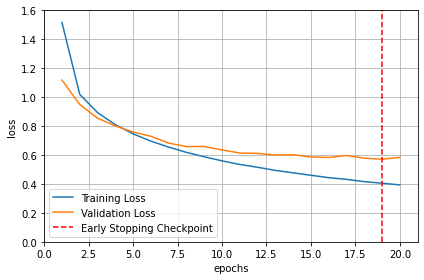

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = avg_valid_losses.index(min(avg_valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.6) # 일정한 scale
plt.xlim(0, len(avg_train_losses)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot_no_drop_out.png', bbox_inches = 'tight')

- dropout o 
- lr = 0.001
- batchsize = 200

In [ ]:
model_drop=CNN_dropout()
criterion_drop = torch.nn.CrossEntropyLoss() # 비용함수에 소프트 맥스 함수 포함되어져 있음
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.001) # Adam을 사용했네 ..

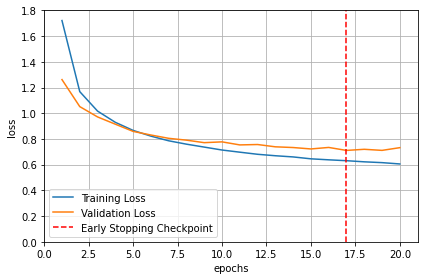

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.8) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
test(test_set,model_drop)

100%|████████████████████████████████████████████████████████████████████████████| 17100/17100 [05:19<00:00, 53.44it/s]

Accuracy: 0.925000011920929 ()


tensor(0.9250)

In [ ]:
model_bn=CNN_bn()
criterion_bn = torch.nn.CrossEntropyLoss() # 비용함수에 소프트 맥스 함수 포함되어져 있음
optimizer_bn = torch.optim.Adam(model_bn.parameters(), lr=0.0005) # Adam을 사용했네 ..
model_bn, train_loss_bn, valid_loss_bn = train_with_epochs(40,model_bn, criterion_bn, optimizer_bn)


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 1/20] train_loss: 2.27651 valid_loss: 1.82094
Validation loss decreased (inf --> 1.820936).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 2/20] train_loss: 1.50661 valid_loss: 1.45819
Validation loss decreased (1.820936 --> 1.458191).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 3/20] train_loss: 1.26037 valid_loss: 1.28155
Validation loss decreased (1.458191 --> 1.281550).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 4/20] train_loss: 1.13117 valid_loss: 1.15622
Validation loss decreased (1.281550 --> 1.156222).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 5/20] train_loss: 1.04436 valid_loss: 1.06106
Validation loss decreased (1.156222 --> 1.061056).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 6/20] train_loss: 0.97568 valid_loss: 1.02997
Validation loss decreased (1.061056 --> 1.029967).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 7/20] train_loss: 0.92650 valid_loss: 0.96853
Validation loss decreased (1.029967 --> 0.968530).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 8/20] train_loss: 0.88301 valid_loss: 0.93134
Validation loss decreased (0.968530 --> 0.931338).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[ 9/20] train_loss: 0.85014 valid_loss: 0.92305
Validation loss decreased (0.931338 --> 0.923046).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[10/20] train_loss: 0.82473 valid_loss: 0.87989
Validation loss decreased (0.923046 --> 0.879892).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[11/20] train_loss: 0.79553 valid_loss: 0.86759
Validation loss decreased (0.879892 --> 0.867588).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[12/20] train_loss: 0.77065 valid_loss: 0.83465
Validation loss decreased (0.867588 --> 0.834653).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[13/20] train_loss: 0.75399 valid_loss: 0.83452
Validation loss decreased (0.834653 --> 0.834519).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[14/20] train_loss: 0.73925 valid_loss: 0.82645
Validation loss decreased (0.834519 --> 0.826454).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[15/20] train_loss: 0.72142 valid_loss: 0.80820
Validation loss decreased (0.826454 --> 0.808197).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[16/20] train_loss: 0.71050 valid_loss: 0.79198
Validation loss decreased (0.808197 --> 0.791985).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[17/20] train_loss: 0.70052 valid_loss: 0.78053
Validation loss decreased (0.791985 --> 0.780527).  Saving model ...


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[18/20] train_loss: 0.68897 valid_loss: 0.78287
EarlyStopping counter: 1 out of 20


  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

[19/20] train_loss: 0.67619 valid_loss: 0.76201
Validation loss decreased (0.780527 --> 0.762014).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.40it/s]

[20/20] train_loss: 0.67040 valid_loss: 0.78127
EarlyStopping counter: 1 out of 20


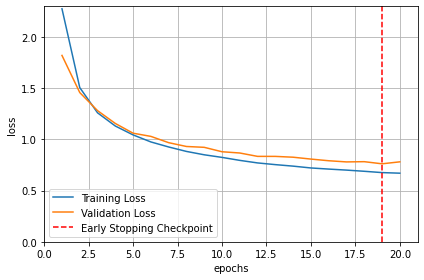

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_loss_bn)+1),train_loss_bn, label='Training Loss')
plt.plot(range(1,len(valid_loss_bn)+1),valid_loss_bn,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss_bn.index(min(valid_loss_bn))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2.3) # 일정한 scale
plt.xlim(0, len(train_loss_bn)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot_bn.png', bbox_inches = 'tight')

In [ ]:
test(test_loader,model3)

100%|████████████████████████████████████████████████████████████████████████████| 17100/17100 [05:39<00:00, 50.36it/s]

Accuracy: 0.8849999904632568 ()


tensor(0.8850)

# 3. Regularization

## 3.1 Early Stopping

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def test(data_loader, model):
    model.eval() # 반드시 필요하다
    n_predict = 0
    n_correct = 0
    with torch.no_grad():
        for x, y in tqdm.tqdm(data_loader):
            y_hat = model(X)
            y_hat.argmax()
            
            _, predicted = torch.max(y_hat,1)
            
            n_predict += len(predicted)
            n_correct += (Y == predicted).sum()
            
        accuracy = n_correct/n_predict
        print(f"Accuracy: {accuracy} ()")
        return accuracy